In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


# Selex (original Multibind)

In [25]:
n_rounds = 1
data = pd.read_csv('../data/countTable.0.CTCF_r3.tsv.gz', sep='\t', header=None)
data.columns = ['seq'] + [i for i in range(n_rounds+1)]
data.index = data['seq']
del data['seq']
data = data.sample(n=1000)
# data.index = range(len(data))
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
# train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [26]:
data

,0,1
seq,,
ATATTAGTTATGTCGCGTCTGCTATAGATG,1,0
AATGTGCTGGTGCTTTTGTTATAGTGAATA,1,0
AGAAGTGGTCGTGGGTTGAGCTGTTGGAGG,1,0
CTTGTAGGTTATAACTTTACGCTGAATTTG,1,0
GGTAGCTGAGCTCAGAGCTAGTAACTAATG,1,0
...,...,...
GATGCCCGGGCACAAGGTGTACGGTGCGGG,0,1
ACGCGGAGCAAATGCTGGTTCATTAAAGGT,1,0
AGAAATAGGCTAATGCAGAGTATACGCAGG,1,0


In [27]:
model = mb.models.Multibind(kernels=[0, 14, 12], datatype="selex", n_rounds=1, n_batches=1).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.PoissonLoss()

In [28]:
mb.tl.train_network(model, train, device, optimiser, criterion, reconstruction_crit=None, num_epochs=500, early_stopping=10, log_each=10, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'multibind.tl.loss.PoissonLoss'> n_epochs 500 early_stopping 10
lr= 0.001, weight_decay= 0.0001, dir weight= 0
Epoch: 11, Loss: 1.663309 , best epoch: 9 secs per epoch: 0.062 s
Epoch: 21, Loss: 1.332551 , best epoch: 19 secs per epoch: 0.060 s
Epoch: 31, Loss: 1.077441 , best epoch: 29 secs per epoch: 0.060 s
Epoch: 41, Loss: 0.933565 , best epoch: 39 secs per epoch: 0.059 s
Epoch: 51, Loss: 0.874410 , best epoch: 49 secs per epoch: 0.060 s
Epoch: 61, Loss: 0.854477 , best epoch: 59 secs per epoch: 0.059 s
Epoch: 71, Loss: 0.848061 , best epoch: 69 secs per epoch: 0.058 s
Epoch: 81, Loss: 0.846159 , best epoch: 79 secs per epoch: 0.057 s
Epoch: 91, Loss: 0.845833 , best epoch: 88 secs per epoch: 0.056 s
Epoch: 101, Loss: 0.845492 , best epoch: 99 secs per epoch: 0.055 s
Epoch: 111, Loss: 0.845479 , best epoch: 101 secs per epoch: 0.055 s
Epoch: 112, Loss: 0.8456 , best epoch: 101 secs per epoch: 0.055 s
early stop!
total time:

# Pbm with Protein Sequences

In [6]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [37]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

# df = df.head(1000)
df = df.reindex(df.var(axis=1).sort_values()[-100:].index)

df

,0,1,2,3,4,5,6,7,8,9,...,168,169,170,171,172,173,174,175,176,177
seq,,,,,,,,,,,,,,,,,,,,,
CGCAGCCGCAGCTGGCGCCCCGGCGTCATAGGTCCCGTCTGTGTTCCGTTGTCCGTGCTG,-0.659682,-0.339073,-0.133640,-1.274016,-2.338438,-0.580987,-0.664403,-1.030671,-0.586772,-0.492374,...,-0.916333,-1.844645,-0.517965,-0.258997,-0.256025,-2.333840,-0.425937,-0.704508,-0.100726,-0.113527
GCCCCCCAGGTCAGACGAGTTGAACTTCAACCCTCCGTCTGTGTTCCGTTGTCCGTGCTG,-0.574053,-0.363282,-0.316799,-0.767258,-0.705346,-0.377647,-0.538784,-1.135303,-0.306191,-0.625336,...,-0.377701,-0.231998,0.068657,-0.061296,0.052286,-0.670127,-0.343824,-0.548323,-0.832650,-0.584504
GATAACCCTTAATTGGTCCTTCGCGATAGAAGGTCCGTCTGTGTTCCGTTGTCCGTGCTG,2.703159,3.578457,6.349597,2.675210,2.475441,3.133558,2.611887,2.589847,3.011796,4.810945,...,2.064428,0.584326,0.001060,0.046085,0.852027,0.996424,3.488596,2.619404,3.006790,3.014480
GGTAGAGGTGGAACCGCGGTACTAATTAGATCAGGCGTCTGTGTTCCGTTGTCCGTGCTG,2.714021,2.838746,6.501419,0.889622,1.492980,0.941923,1.278587,1.700570,1.883797,4.067142,...,0.530237,0.147995,-0.161132,-0.176242,-0.952434,0.843187,4.228793,2.126193,2.044937,2.820259
TGTGTAATTAATAAGTCCCACCATTCCACTTAGGTTGTCTGTGTTCCGTTGTCCGTGCTG,3.283341,3.833442,6.952337,2.223529,2.219933,2.355134,2.030986,2.430479,2.813665,4.681918,...,1.453141,0.669079,-0.152009,-0.042625,1.240002,0.879946,5.029708,2.767530,3.509563,3.446345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTCGTGGCGTTCGCGACCATCGCAAACACGCTTTAGTCTGTGTTCCGTTGTCCGTGCTG,-0.142679,-0.291169,-0.218436,-0.771649,-0.031972,-0.237209,-0.187451,-0.494980,-0.355316,-0.088961,...,-0.790043,-0.125247,-0.058295,-0.079560,-0.053942,0.105131,-0.196084,-0.202346,0.113713,0.414194
TCGTACCAGCATTTATCAGGTAGCGGAGTGCCAAATGTCTGTGTTCCGTTGTCCGTGCTG,-0.340468,-0.189254,0.206141,0.418631,1.773758,1.444734,0.402644,0.688725,0.453532,0.355970,...,0.188191,-0.068568,0.237085,-0.025857,-0.304529,0.398035,0.306394,-0.003307,-0.533505,-0.258099
CGTTAATCGTGCAGTAGTTACGGTGCATTCAACATCGTCTGTGTTCCGTTGTCCGTGCTG,0.306300,0.225155,1.534268,0.188276,1.905877,1.456514,1.560607,1.662665,2.553022,1.218580,...,2.835337,0.808221,-0.211474,-37.334557,-0.893831,0.313406,0.731129,1.070064,0.936499,0.363930


In [38]:
dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [39]:
# Set up the model
bm_generator = mb.models.BMPrediction(num_classes=1, input_size=21, hidden_size=2, num_layers=1, seq_length=88)
model = mb.models.Multibind(datatype='pbm', bm_generator=bm_generator)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = None  # torch.nn.CrossEntropyLoss()

In [40]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 3.839516 , best epoch: 0 secs per epoch: 4.567 s
Epoch:  3, Loss: 3.806435 , best epoch: 1 secs per epoch: 3.462 s
Epoch:  4, Loss: 3.776480 , best epoch: 2 secs per epoch: 3.053 s
Epoch:  5, Loss: 4.098220 , best epoch: 3 secs per epoch: 2.844 s
Epoch:  6, Loss: 3.735839 , best epoch: 3 secs per epoch: 2.720 s
Epoch:  7, Loss: 3.717218 , best epoch: 5 secs per epoch: 2.638 s
Epoch:  8, Loss: 3.695341 , best epoch: 6 secs per epoch: 2.584 s
Epoch:  9, Loss: 3.692739 , best epoch: 7 secs per epoch: 2.541 s
Epoch: 10, Loss: 3.674153 , best epoch: 8 secs per epoch: 2.528 s
Epoch: 11, Loss: 3.663430 , best epoch: 9 secs per epoch: 2.507 s
Epoch: 12, Loss: 3.656608 , best epoch: 10 secs per epoch: 2.483 s
Epoch: 13, Loss: 3.655979 , best epoch: 11 secs per epoch: 2.464 s
Epoch: 14, Loss: 3.639743 , best epoch: 1

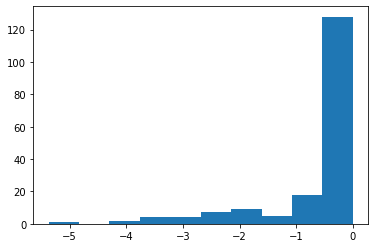

array([-1.51725709e-01, -4.34807598e-01, -9.98266869e-01, -1.29532902e-02,
       -1.77352909e-02, -5.75645423e-02, -8.15226863e-04, -8.95453833e-03,
       -2.40579691e-01, -6.45041137e-01, -1.08837638e-01, -1.06397372e-02,
       -2.98984245e-03, -3.83915077e+00, -2.54638318e-01, -4.29186495e-01,
       -9.59734534e-01, -1.93403561e+00, -1.63423174e-01, -9.85208419e-02,
       -2.54157240e-01, -3.37039109e-01, -5.56941123e-02, -8.21773384e-04,
       -6.79660678e-01, -3.00381999e+00, -1.31656625e+00, -9.51186713e-03,
       -3.40572769e-01, -1.08125729e-01, -5.93263087e-02, -5.08810510e-01,
       -4.43059351e-01, -5.27673051e-03, -1.51042553e-02, -6.12159566e-02,
       -2.54922475e-01, -1.92653156e-03, -3.62162822e+00, -3.02147004e-01,
       -1.42970263e-01, -2.09402447e+00, -6.94853571e-04, -7.03607807e-03,
       -4.19332906e-02, -7.93078707e-02, -2.42615943e-01, -4.73804064e-01,
       -2.74094548e-01, -1.35538983e-01, -4.67760953e-02, -4.26632657e-01,
       -5.33212963e-02, -

In [44]:
mb.pl.R2_per_protein(model, train, device)

# PBM: Leaving out one column (one TF)

In [49]:
train_df = df[range(1, 178)].copy()
test_df = df[[0]].copy()

train_dataset = mb.datasets.ResiduePBMDataset(train_df, x[1:178])
train = tdata.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataset = mb.datasets.ResiduePBMDataset(test_df, x[0:1])
test = tdata.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [50]:
# Set up the model
bm_generator = mb.models.BMPrediction(num_classes=1, input_size=21, hidden_size=2, num_layers=1, seq_length=88)
model = mb.models.Multibind(datatype='pbm', bm_generator=bm_generator)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
reconstruction_crit = None  # torch.nn.CrossEntropyLoss()

In [51]:
mb.tl.train_network(model, train, device, optimizer, criterion, reconstruction_crit, num_epochs=15, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 3.852249 , best epoch: 0 secs per epoch: 4.527 s
Epoch:  3, Loss: 3.839876 , best epoch: 1 secs per epoch: 3.399 s
Epoch:  4, Loss: 3.831847 , best epoch: 2 secs per epoch: 3.040 s
Epoch:  5, Loss: 3.816430 , best epoch: 3 secs per epoch: 2.871 s
Epoch:  6, Loss: 3.800573 , best epoch: 4 secs per epoch: 2.780 s
Epoch:  7, Loss: 3.781076 , best epoch: 5 secs per epoch: 2.710 s
Epoch:  8, Loss: 3.754061 , best epoch: 6 secs per epoch: 2.634 s
Epoch:  9, Loss: 3.698286 , best epoch: 7 secs per epoch: 2.584 s
Epoch: 10, Loss: 3.652230 , best epoch: 8 secs per epoch: 2.560 s
Epoch: 11, Loss: 3.648653 , best epoch: 9 secs per epoch: 2.531 s
Epoch: 12, Loss: 3.634452 , best epoch: 10 secs per epoch: 2.504 s
Epoch: 13, Loss: 3.624289 , best epoch: 11 secs per epoch: 2.488 s
Epoch: 14, Loss: 3.628742 , best epoch: 1

In [53]:
mb.pl.R2_per_protein(model, test, device, show_plot=False)

array([-0.16558366])